<a href="https://colab.research.google.com/github/HatimCodeforever/RS_experiments/blob/master/Rs_exp6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

In [ ]:
!pip install surprise

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import re
import os
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, Ridge
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import HTML
from IPython.display import Image as _image

tqdm.pandas()

import datetime

import pyspark
from pyspark.ml import Pipeline
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.regression import FMRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import (StringIndexer, VectorAssembler, VectorIndexer,
                                OneHotEncoder)

from surprise import Reader, Dataset, KNNWithMeans

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Download nltk requirements
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')


ML_COLORS = ['darkorange']

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<style>
.output_png {
    display: table-cell;
    text-align: center;
    horizontal-align: middle;
    vertical-align: middle;
    margin:auto;
}

tbody, thead {
    margin-left:100px;
}

</style>
<form action="javascript:code_toggle()"><input type="submit"
value="Click here to toggle on/off the raw code."></form>''')

In [ ]:
# define the context aware recommender system
# code revised from prof leo's code. thank you!

class ContextAwareRS:
    """Base class for context-aware recommender systems"""

    def __init__(self, data, context_vars, rating_scale, sim_options=None):
        """Initialize the context aware recommender system given the
        ratings data and context variables
        """
        # Initialize static variables
        self.data = data
        self.context_vars = context_vars
        self.rating_scale = rating_scale
        if sim_options is None:
            self.sim_options = {'name': 'pearson', 'user_based': False,
                                'min_support': 0, 'shrinkage': 0}
        else:
            self.sim_options = sim_options

        # Initialize recsys model
        self.model = None

class ContextPreFiltering(ContextAwareRS):
    """Class for implementing context prefiltering algorithm with a
    neighborhood-based collaborative filtering algorithm
    """

    def __init__(
        self, data, context_vars, rating_scale, sim_options=None, k=None):
        """Initialize the context-prefiltering model"""
        super().__init__(data, context_vars, sim_options)
        if k is None:
            self.k = 5
        else:
            self.k = k

        # Initialize current data - this will be the 'filtered' data
        # based on context
        self.cur_data = None

    def fit(self, context_var_values):
        """Fit a context-aware recsys given context_vars_value"""
        # Get current data based on given context values
        cur_data = self.data.copy()
        for col, val in zip(self.context_vars, context_var_values):
            # If a None value is given, skip that column
            if val is not None:
                cur_data = cur_data.loc[cur_data.loc[:, col] == val]

        # Append to the CPF object for reference later
        self.cur_data = cur_data

        # Perform KNNWithMeans training
        reader = Reader(self.rating_scale)
        dataset = Dataset.load_from_df(self.cur_data.iloc[:, :3], reader)
        knn = KNNWithMeans(k=self.k, sim_options=self.sim_options)
        knn.fit(dataset.build_full_trainset())

        # Save model to object
        self.model = knn

    def show_top_k(self, user_id, top_k=20):
        """Return the context-aware top-k recommendations for user"""
        # Retrieve items not seen by the user
        seen_items = (self.cur_data[self.cur_data.iloc[:, 0] == user_id]
                      .iloc[:, 1].unique())
        #if seen_items == []:
        #    print('no seen movies, so recomms will have same rating')
        #else:
        #    pass
        unseen_items = (
            self.cur_data[~self.cur_data.iloc[:, 1].isin(seen_items)]
            .iloc[:, 1].unique()
        )

        #return seen_items

        # Generate predictions
        predictions = [self.model.predict(user_id, item)
                       for item in unseen_items]

        # Sort predictions based on estimated rating
        return [(prediction.iid, prediction.est)
                for prediction in sorted(predictions,
                                         key=lambda x: -x.est)][:top_k]

class ContextPostFiltering(ContextAwareRS):
    """Class for implementing context postfiltering algorithm with a
    neighborhood-based collaborative filtering algorithm
    """

    def __init__(
        self, data, context_vars, rating_scale, sim_options=None, k=None):
        """Initialize the context-prefiltering model"""
        super().__init__(data, context_vars, sim_options)
        if k is None:
            self.k = 5
        else:
            self.k = k

        # Initialize filter matrix. This will be used to filter the
        # resulting ratings at prediction time
        self.cur_data = None
        self.filter_matrix = None

    def fit(self, context_var_values, min_rating=3):
        """Fit a context-aware recsys given context_vars_value"""
        # Get current data based on given context values
        cur_data = self.data.copy()
        for col, val in zip(self.context_vars, context_var_values):
            # If a None value is given, skip that column
            if val is not None:
                cur_data = cur_data.loc[cur_data.loc[:, col] == val]
        self.cur_data =cur_data

        # Solve for the filter matrix. Here, we take P(*, i, c) as the
        # ratio between users who rate the movie with
        # stars > min_rating, over the total number of users.
        filter_matrix = cur_data.groupby('movieid').rating.apply(
            lambda x: (x >= min_rating).sum() / len(x)
        )
        self.filter_matrix = filter_matrix

        # Aggregate data into two-dimensional ratings matrix
        aggregate_data = (self.data.groupby(self.data.columns[:2].tolist())
                          .rating.mean().reset_index())

        # Perform KNNWithMeans training
        reader = Reader(self.rating_scale)
        dataset = Dataset.load_from_df(aggregate_data, reader)
        knn = KNNWithMeans(k=self.k, sim_options=self.sim_options)
        knn.fit(dataset.build_full_trainset())

        # Save model to object
        self.model = knn

    def show_top_k(self, user_id, top_k=20):
        """Return the context-aware top-k recommendations for user"""
        # Retrieve items not seen by the user
        seen_items = (self.cur_data[self.cur_data.iloc[:, 0] == user_id]
                      .iloc[:, 1].unique())
        if seen_items == []:
            print('no seen movies, so recomms will have same rating')
        else:
            pass
        unseen_items = (
            self.cur_data[~self.cur_data.iloc[:, 1].isin(seen_items)]
            .iloc[:, 1].unique()
        )

        # Generate predictions
        predictions = pd.DataFrame([self.model.predict(user_id, item)
                                    for item in unseen_items])
        predictions = predictions.set_index(predictions.columns[1]).est

        # Perform the post-filtering process
        predictions = ((predictions * self.filter_matrix)
                       .sort_values(ascending=False))

        # Sort predictions based on estimated rating
        return predictions[:top_k]

class ContextualModeling(ContextAwareRS):
    """Class for implmenting contextual modeling using factorization
    machines
    """

    def __init__(self, data, context_vars):
        """Initialize the contextual modeling recommender system"""
        super().__init__(data, context_vars, None)

    def fit(self):
        """Fit given the context variable values"""
        # Set the pipeline for the Factorization machines
        pipe = Pipeline(stages=[
            # Create string indices for each string variable
            StringIndexer(
                inputCols=['userid', 'movieid'],
                outputCols=['useridIndex', 'movieidIndex']),

            # One hot encode variables
            OneHotEncoder(
                inputCols=['useridIndex', 'movieidIndex', 'age',
                           'occupations'],
                outputCols=['userID', 'movieID', 'ageID', 'occID']),

            # Assemble onto one vector
            VectorAssembler(
                inputCols=['userID', 'movieID', 'ageID', 'gender', 'occID'],
                outputCol='features', handleInvalid='skip'),

            # Train a FM model
            FMRegressor(
                featuresCol='features', labelCol='rating', stepSize=0.001)
        ])

        # Create spark data frame then fit the model to it
        sdf = spark.createDataFrame(self.data)
        model = pipe.fit(sdf)

        # Save the model to object
        self.model = model

    def show_top_k(self, user_id, context_var_values, top_k=20):
        """Return the context-aware top-k recommendations for user"""
        # Get current data based on given context values
        cur_data = self.data.copy()
        for col, val in zip(self.context_vars, context_var_values):
            # If a None value is given, skip that column
            if val is not None:
                cur_data = cur_data.loc[cur_data.loc[:, col] == val]

        # Retrieve items not seen by the user
        seen_items = (cur_data[cur_data.iloc[:, 0] == user_id].iloc[:, 1]
                      .unique())
        unseen_items = (cur_data[~cur_data.iloc[:, 1].isin(seen_items)]
                        .iloc[:, 1].unique())

        # Setup test data frame
        test_df = pd.DataFrame({'movieid': unseen_items})
        test_df.loc[:, self.data.columns[0]] = user_id
        test_df.loc[:, self.context_vars[0]] = context_var_values[0]
        test_df.loc[:, self.context_vars[1]] = context_var_values[1]
        test_df.loc[:, self.context_vars[2]] = context_var_values[2]
        test_sdf = spark.createDataFrame(test_df)

        # Get predictions
        predictions = (self.model.transform(test_sdf)
                       .select(['movieid', 'prediction'])
                       .toPandas().sort_values('prediction', ascending=False))

        # Sort predictions based on estimated rating
        return predictions[:top_k]

In [ ]:
movies = pd.read_csv('movies.csv')
users = pd.read_csv('users.csv')
ratings = pd.read_csv('ratings.csv')

In [ ]:
merged = pd.merge(ratings, movies, on='movieid')

# merge it into the user information
final = pd.merge(merged, users, on='userid')

final.head()

,userid,movieid,rating,timestamp,title,genre,gender,age,occupations,zip
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,['Drama'],F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach,"['Animation', ""Children's"", 'Musical']",F,1,10,48067
2,1,914,3,978301968,My Fair Lady,"['Musical', 'Romance']",F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich,['Drama'],F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A","['Animation', ""Children's"", 'Comedy']",F,1,10,48067


In [ ]:
print(final[final.userid == 158][['rating', 'title']])

        rating                                              title
101648       2                                    Ghostbusters II
101649       4                                         Casablanca
101650       4                                    Misérables, Les
101651       5                                        Taxi Driver
101652       5                                          Chinatown
101653       3                                       Citizen Kane
101654       3                                      All About Eve
101655       5                                     Godfather, The
101656       4                           Ghost and Mrs. Muir, The
101657       4                                 Lawrence of Arabia
101658       5                                  Great Escape, The
101659       4                                     Big Sleep, The
101660       5                                Long Walk Home, The
101661       4  Seven Samurai (The Magnificent Seven) (Shichin...
101662    

In [ ]:
display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 7. Jose's Seen & Rated Movies
</b></p>'''))

display(final[final.userid == 1][['rating', 'title']])

,rating,title
0,5,One Flew Over the Cuckoo's Nest
1,3,James and the Giant Peach
2,3,My Fair Lady
3,4,Erin Brockovich
4,5,"Bug's Life, A"
5,3,"Princess Bride, The"
6,5,Ben-Hur
7,5,"Christmas Story, A"
8,4,Snow White and the Seven Dwarfs
9,4,"Wizard of Oz, The"


In [ ]:
rename = {"occupations": {0: "other", 1: "academic/educator", 2: "artist",
                          3: "clerical/admin",  4: "college/grad student",
                          5: "customer service",  6: "doctor/health care",
                          7: "executive/managerial", 8: "farmer",
                          9: "homemaker", 10: "K-12 student", 11: "lawyer",
                          12: "programmer", 13: "retired",
                          14: "sales/marketing", 15: "scientist",
                          16: "self-employed", 17: "technician/engineer",
                          18: "tradesman/craftsman", 19: "unemployed",
                          20: "writer"},
         "age": {1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44",
                 45: "45-49", 50: "50-55", 56: "56+"}}

In [ ]:
df_movies

,movieid,title,genre,title_genre,clean
0,1,Toy Story,"['Animation', ""Children's"", 'Comedy']",Toy Story Animation Childrens Comedy,story animation childrens comedy
1,2,Jumanji,"['Adventure', ""Children's"", 'Fantasy']",Jumanji Adventure Childrens Fantasy,jumanji adventure childrens fantasy
2,3,Grumpier Old Men,"['Comedy', 'Romance']",Grumpier Old Men Comedy Romance,grumpier comedy romance
3,4,Waiting to Exhale,"['Comedy', 'Drama']",Waiting to Exhale Comedy Drama,waiting exhale comedy drama
4,5,Father of the Bride Part II,['Comedy'],Father of the Bride Part II Comedy,father bride part comedy
...,...,...,...,...,...
3878,3948,Meet the Parents,['Comedy'],Meet the Parents Comedy,meet parent comedy
3879,3949,Requiem for a Dream,['Drama'],Requiem for a Dream Drama,requiem dream drama
3880,3950,Tigerland,['Drama'],Tigerland Drama,tigerland drama
3881,3951,Two Family House,['Drama'],Two Family House Drama,family house drama


genre  Childrens     162
 Comedy        176
 SciFi         230
Horror         262
 Thriller      391
 Romance       421
 Drama         427
Action         503
Comedy        1024
Drama         1176
Name: genre, dtype: int64


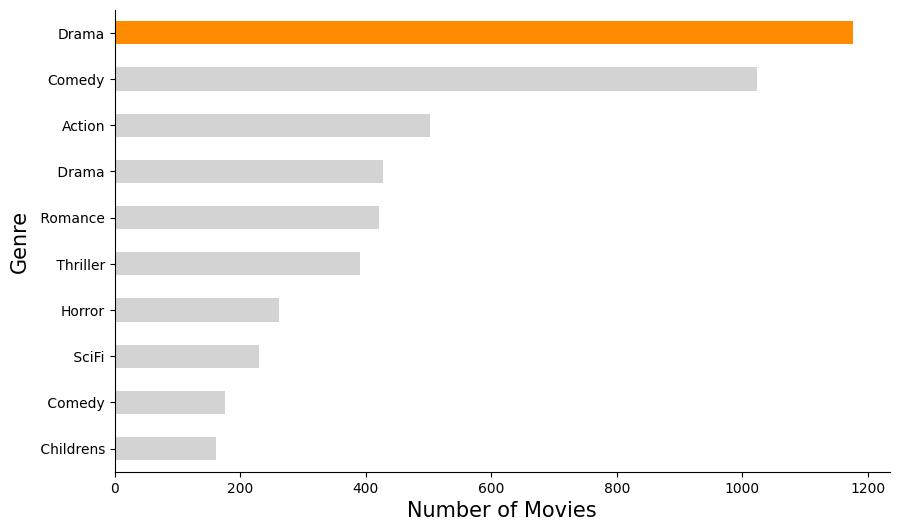

In [ ]:
df_movies = movies.copy()
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 1. Top 10 genre with largest movie count.
</b></center>'''))
genre = (df_movies.genre.str.split(',')
                  .apply(lambda x: [re.sub(r'[^\w\s]', '', i) for i in x])
                  .explode()
                  .value_counts()[:10][::-1]/)

display(HTML(f'''<h3 style="text-align:center">
                Most of the movies in MovieLens have
                <b style="color:{"darkorange"}">
                drama</b> genre
                </h3>'''))
print("genre",genre)
plt.figure(figsize=(10, 6))
genre.plot.barh(color= ['lightgray'] * (len(genre) - 1) + ['darkorange'])
plt.xlabel("Number of Movies", fontsize=15)
plt.ylabel("Genre", fontsize=15)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

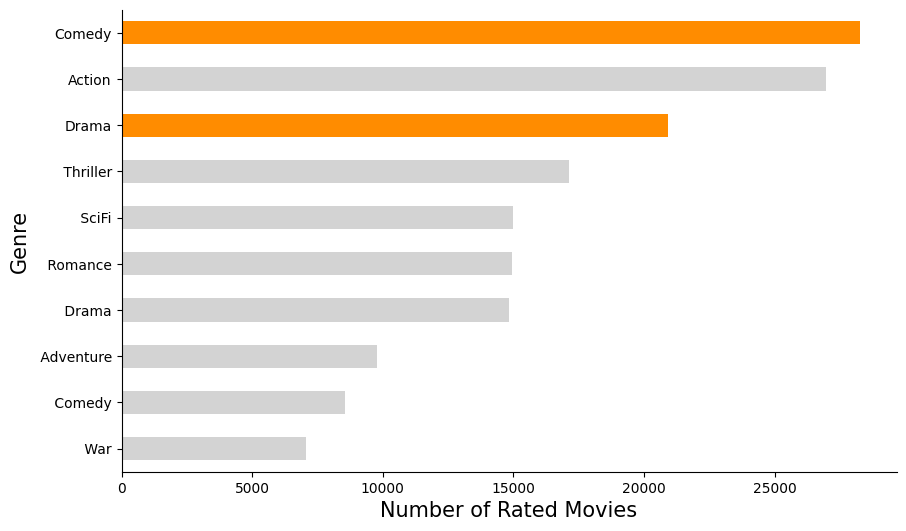

In [ ]:
genre = (final.genre.str.split(',')
                  .apply(lambda x: [re.sub(r'[^\w\s]', '', i) for i in x])
                  .explode()
                  .value_counts()[:10][::-1])
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 2. Top 10 genre with most rated counts.
</b></center>'''))

display(HTML(f'''<h3 style="text-align:center">
                Most rated movies of MovieLens
                have<b style="color:{"orange"}">
                comedy</b> genre
                </h3>'''))


plt.figure(figsize=(10, 6))
genre.plot.barh(color= ['lightgray'] * (len(genre) - 3) + ['darkorange']
                + ['lightgray'] + ['darkorange'])
plt.xlabel("Number of Rated Movies", fontsize=15)
plt.ylabel("Genre", fontsize=15)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

<built-in function eval>


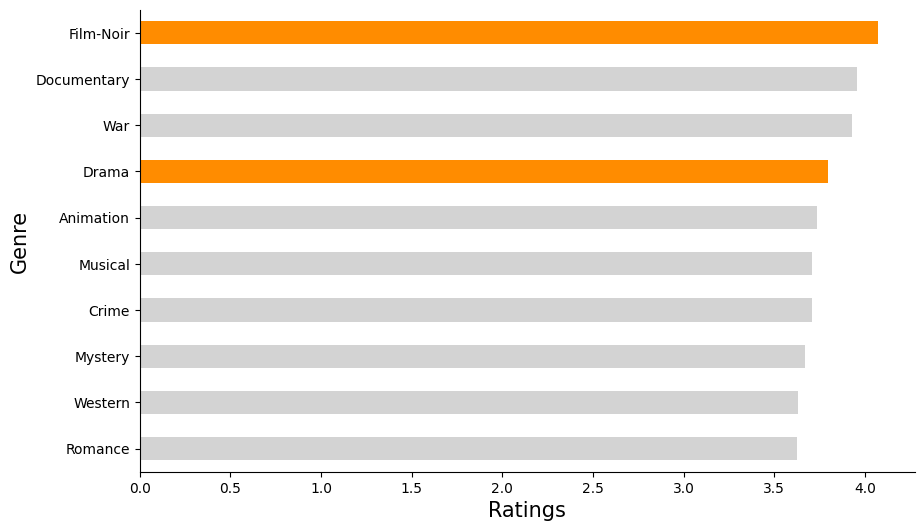

In [ ]:
display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 3. Top 10 genre with highest average ratings.
</b></center>'''))

display(HTML(f'''<h3 style="text-align:center">
                <b style="color:{"orange"}">
                Film Noir</b> has the highest average ratings
                </h3>'''))


plt.figure(figsize=(10, 6))

eda = final.copy()
eda['genre'] = eda.genre.apply(eval)
(eda.loc[:, ['genre', 'rating']].explode('genre')
   .groupby('genre')['rating'].mean()
   .sort_values(ascending=False)[:10][::-1]
   .plot.barh(color= ['lightgray'] * (len(genre) - 4) + ['darkorange']
                     + ['lightgray'] * 2 + ['darkorange']))
plt.xlabel("Ratings", fontsize=15)
plt.ylabel("Genre", fontsize=15)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

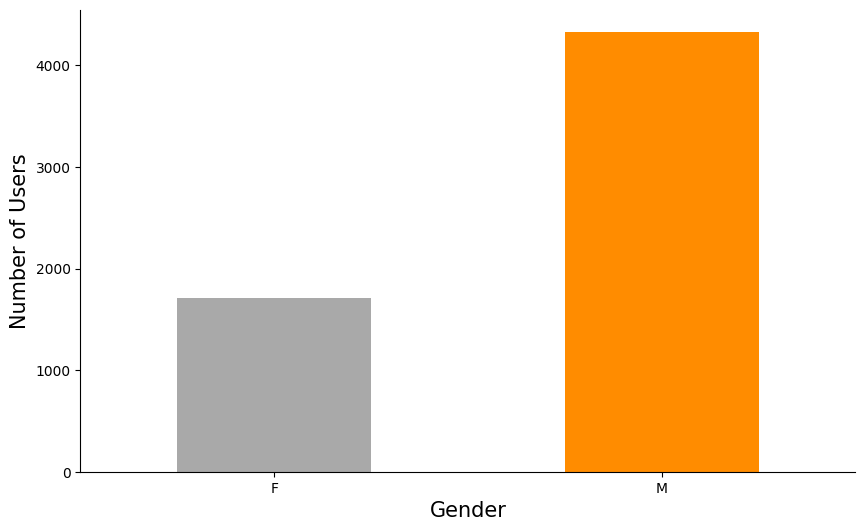

In [ ]:
user_plot = users.replace(rename)

display(HTML('''<center style="font-size:12px;font-style:default;"><b>
Figure 4. User Distribution per Gender.
</b></center>'''))

gender_plot = (user_plot.gender.value_counts(ascending=True))

display(HTML(f'''<h3 style="text-align:center">
                Number of users based on<b style="color:{"orange"}">
                gender</b>
                </h3>'''))


plt.figure(figsize=(10, 6))
gender_plot.plot.bar(color= ['darkgray'] * (len(gender_plot) - 1) + ['darkorange'])
plt.ylabel("Number of Users", fontsize=15)
plt.xlabel("Gender", fontsize=15)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
df = pd.read_csv('final.csv')
df_movies = pd.read_csv('movies.csv')

def preprocess_movies(df_movies):
    """ Preprocess the content metadata of the movie

    Parameters
    ===========
    df_movies    :    pandas.DataFrame
                      database

    Returns
    ===========
    preprocess_movies   :  tuple
                           tuple of database and tfidf transformed data
    """
    df_movies['title_genre'] = df_movies.title +  ' '  + df_movies.genre
    df_movies['title_genre'] = df_movies.title_genre.str.replace(r'[^\w\s]',
                                                            '', regex=True)

    # tokenize
    tokenize = df_movies.title_genre.apply(nltk.word_tokenize)

    # casefold
    lower_case = tokenize.apply(lambda x:list(map(lambda y: y.casefold(), x)))


    # lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatize = lower_case.apply(lambda x: list(map(lemmatizer.lemmatize,
                                                             x)))

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_stopwords = lemmatize.apply(lambda x:
                                        list(filter(lambda y: y
                                                not in stop_words,
                                                              x)))

    # filter words with less than 3 character length
    filtered_words = filtered_stopwords.apply(lambda x:
                                                       list(filter(lambda y:
                                                                   len(y) > 3,
                                                                   x)))

    df_movies['clean'] = (filtered_words.apply(' '.join))

    tfidf_vectorizer = TfidfVectorizer(token_pattern=r'\b[a-z]+\b',
                                       ngram_range=(1, 2),
                                       max_df=0.8,
                                       min_df=0.01)


    tfidf = tfidf_vectorizer.fit_transform(df_movies.clean)

    svd = TruncatedSVD(n_components=20, random_state=0)
    X_new = svd.fit_transform(tfidf)

    return df_movies, X_new

In [ ]:
def content_recom(user, df, df_movies, X_new, top_k=10, **kwargs):
    """ Perform content model based recommender sytem for a single user

    Parameters
    ===========
    user        :    int
                     user id
    df          :    pandas.DataFrame
                     full database
    df_movies   :    pandas.DataFrame
                     movies database
    X_new       :    numpy.ndarray
                     tfidf transformed features
    top_k       :    int
                     number of recommendations

    Returns
    ===========
    content_recom  : pandas.DataFrame
                     dataframe of recommended movies
    """
    if 'pre' in kwargs.keys():
        df = df[df[kwargs['context_var']] == kwargs['context_var_value']]
        df = df.reset_index()

    recom = {}
    df_user = df[df.userid==user].copy().sort_values(by='movieid')
    profile = {
    'user': df_user.userid.unique()[0],
    'gender' : df_user.gender.unique()[0],
    'timestamp' : None,
    'age' : df_user.age.unique()[0],
    'occupations' : df_user.occupations.unique()[0],
    'zip' : df_user.zip.unique()[0],
    }

    df_out = pd.DataFrame()

    seen = set(df_user.movieid)
    unseen = set(df.movieid) - seen
    df_movies = df_movies.sort_values(by='movieid')
    movie_index_seen = df_movies[df_movies.movieid.isin(
            sorted(seen))].index

    X = X_new[movie_index_seen]
    y = df_user.rating.to_numpy()
    movie_index_unseen = df_movies[df_movies.movieid.isin(
        sorted(unseen))].index
    X_test = X_new[movie_index_unseen, :]
    model = Ridge(random_state=143)

    try:
        model.fit(X, y)
        new_rating = model.predict(X_test)
        limit = len(new_rating) if 'post' in kwargs.keys() else top_k
        top_recom = np.argsort(new_rating, kind='mergesort')[::-1][:limit]
        top_item = np.array(sorted(unseen))[top_recom]
        for i, item in enumerate(top_item):
            temp = profile.copy()
            temp['movieid'] = item
            temp['title'] = df_movies[df_movies.movieid ==
                                      item].title.to_list()[0]
            temp['genre'] = df_movies[df_movies.movieid ==
                                      item].genre.to_list()[0]
            temp['rating'] = new_rating[top_recom[i]]
            df_out = df_out.append(pd.DataFrame(temp,
                                   index=[0])).reset_index(drop=True)

    except ValueError:
        pass

    if 'post' in kwargs.keys():
        df_out = df_out[df_out[kwargs['context_var']] ==
                        kwargs['context_var_value']]

    return df_out[:top_k]

In [ ]:
display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 8. Maria's Recommended movies based on content metadata
</b></p>'''))

df_movies, X_new = preprocess_movies(df_movies)
display(content_recom(1, df, df_movies, X_new).iloc[:, [0, 6, 7, 8]])

<ipython-input-26-97b7676bed9a>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append(pd.DataFrame(temp,
<ipython-input-26-97b7676bed9a>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append(pd.DataFrame(temp,
<ipython-input-26-97b7676bed9a>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append(pd.DataFrame(temp,
<ipython-input-26-97b7676bed9a>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append(pd.DataFrame(temp,
<ipython-input-26-97b7676bed9a>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

,user,movieid,title,genre
0,1,1812,Wide Awake,"[""Children's"", 'Comedy', 'Drama']"
1,1,1014,Pollyanna,"[""Children's"", 'Comedy', 'Drama']"
2,1,34,Babe,"[""Children's"", 'Comedy', 'Drama']"
3,1,1288,This Is Spinal Tap,"['Comedy', 'Drama', 'Musical']"
4,1,3156,Bicentennial Man,"['Comedy', 'Drama', 'Sci-Fi']"
5,1,1916,Buffalo 66,"['Action', 'Comedy', 'Drama']"
6,1,390,Faster Pussycat! Kill! Kill!,"['Action', 'Comedy', 'Drama']"
7,1,21,Get Shorty,"['Action', 'Comedy', 'Drama']"
8,1,1739,3 Ninjas: High Noon On Mega Mountain,"['Action', ""Children's""]"
9,1,502,"Next Karate Kid, The","['Action', ""Children's""]"


In [ ]:
display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 9. Jose's Recommended movies based on content metadata
</b></p>'''))

df_movies, X_new = preprocess_movies(df_movies)
display(content_recom(2, df, df_movies, X_new).iloc[:, [0, 6, 7, 8]])

<ipython-input-26-97b7676bed9a>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append(pd.DataFrame(temp,
<ipython-input-26-97b7676bed9a>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append(pd.DataFrame(temp,
<ipython-input-26-97b7676bed9a>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append(pd.DataFrame(temp,
<ipython-input-26-97b7676bed9a>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_out = df_out.append(pd.DataFrame(temp,
<ipython-input-26-97b7676bed9a>:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

,user,movieid,title,genre
0,2,3871,Shane,"['Drama', 'Western']"
1,2,3737,Lonely Are the Brave,"['Drama', 'Western']"
2,2,3467,Hud,"['Drama', 'Western']"
3,2,3093,McCabe & Mrs. Miller,"['Drama', 'Western']"
4,2,458,Geronimo: An American Legend,"['Drama', 'Western']"
5,2,3494,True Grit,"['Adventure', 'Western']"
6,2,3806,MacKenna's Gold,['Western']
7,2,3792,Duel in the Sun,['Western']
8,2,3682,Magnum Force,['Western']
9,2,3681,For a Few Dollars More,['Western']


In [ ]:
sample = final.copy()
sample = sample[['userid', 'movieid', 'rating',
                 'gender', 'age', 'occupations']]
encode_nums = {"gender":     {"M": 0, "F": 1},
               "age": {1 : 0, 18 : 1, 25 : 2, 35 : 3,
                       45 : 4, 50 : 5, 56 : 6 }}
sample = sample.replace(encode_nums)

In [ ]:
cpre = ContextPreFiltering(sample, ['gender'], (1, 5))
cpre.fit([1])
cpre_recommendations1 = cpre.show_top_k(3388)
recom_table = final.loc[[i[0] for i in cpre_recommendations1], ['title']]
recom_table['ratings'] = [i[1] for i in cpre_recommendations1]

display(HTML('''<p style="font-size:12px;font-style:default;"><b>
Table 10. Maria's Recommendations - Gender Filter (Female)
</b></p>'''))
display(recom_table)

Computing the pearson similarity matrix...
Done computing similarity matrix.


,title,ratings
1193,Breakfast at Tiffany's,3.66293
661,Ronin,3.66293
914,Last Action Hero,3.66293
3408,Heavenly Creatures,3.66293
2355,Courage Under Fire,3.66293
1197,American Beauty,3.66293
1287,Roger & Me,3.66293
2804,F/X,3.66293
594,Screamers,3.66293
919,Menace II Society,3.66293
